In [1]:
#from homology_basis.cellular_homology import HomologyBasis
import numpy as np
import matplotlib.pyplot as plt
#from scipy.spatial.distance import cdist
#from itertools import product
from itertools import combinations
import gudhi
from miniball import Miniball
from time import time
from scipy.spatial import Delaunay
from scipy.spatial import KDTree

In [13]:
rng = np.random.default_rng(seed=0)

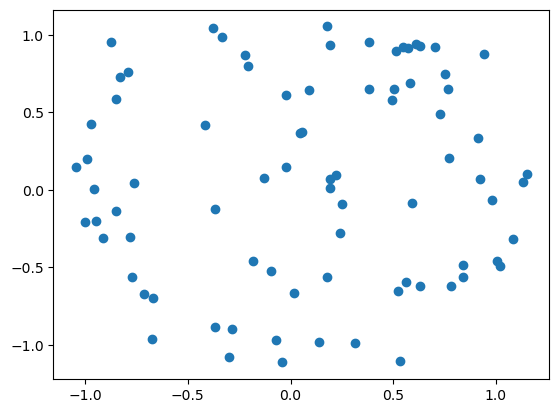

In [3]:
N = 40
M = 40
t = np.linspace(0, 2*np.pi, N, endpoint=False)
X = np.empty((t.size, 2))
X[:, 0] = np.cos(t)
X[:, 1] = np.sin(t)
X = X + 0.1 * rng.standard_normal(X.shape)
Y = 2 * rng.random((M, 2)) - np.array([1, 1])
X = np.vstack((X, Y))
#A = cdist(X, X)
plt.scatter(*X.T)

In [121]:
#Returns dictionary (x,y):filtval, along the line k= r*slope
def core(X,k,max_dim=1,return_squared=False):
    kd_tree = KDTree(X)
    k_core_distances, _ = kd_tree.query(X, k=k)
    if k > 1:
        k_core_distances = k_core_distances[:, -1]
    st = gudhi.SimplexTree()
    for dim in range(max_dim+1):
        for face in combinations(range(len(X)),dim+1):
            face_list = list(face)
            max_core = max(k_core_distances[face_list])
            squared_radius = Miniball(X[face_list]).squared_radius()
            if not return_squared:
                st.insert(face, max(squared_radius ** 0.5, max_core))
            else:
                st.insert(face, max(squared_radius, max_core**2))
    return st         

In [5]:
from core import core_cech
# core_cech(points, max_dim=1, max_k=None, max_r=None, return_squared=False):

In [6]:
t0 = time()
#st_core = core(X=X,max_dim=2,k=1,return_squared=True)
st_core = core_cech(points=X,max_dim=2,max_k=1,return_squared=True)
t1 = time()
print(f"Used {t1-t0:.3f} seconds, on {N+M} points.")

Used 1.975 seconds, on 80 points.


### Compute and show persistence diagrams

/home/odinhg/.local/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

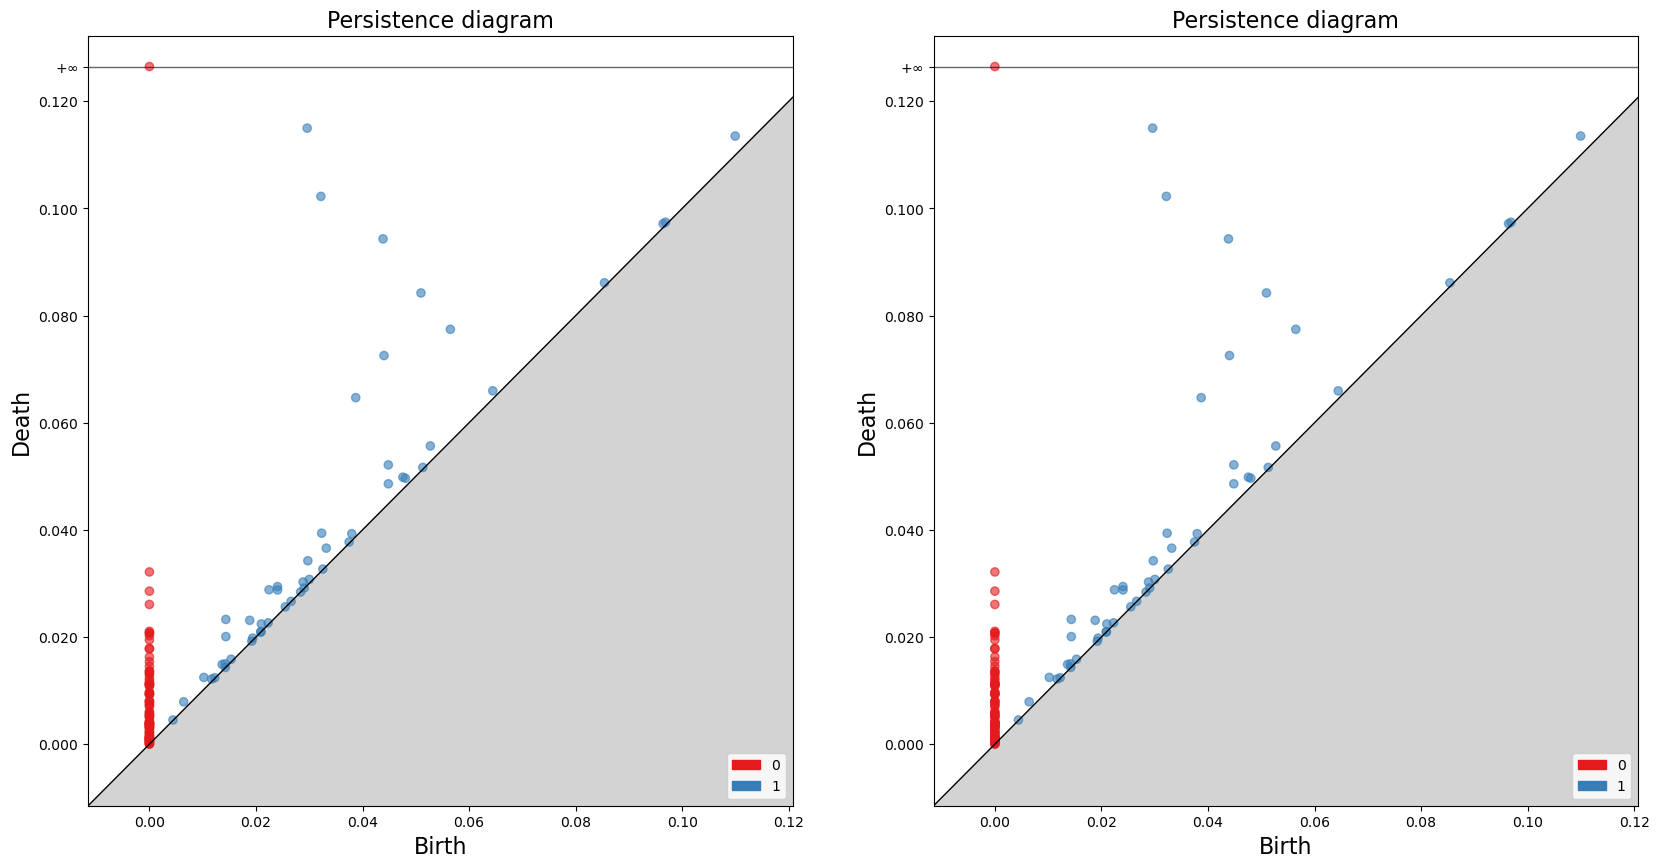

In [7]:
#Compare Core with Alpha for k=1
st_alp = gudhi.AlphaComplex(points=X, precision = 'exact').create_simplex_tree()
fig, axs = plt.subplots(ncols=2, figsize=(20,10))

gudhi.plot_persistence_diagram(st_alp.persistence(), axes=axs[0])
gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[1])

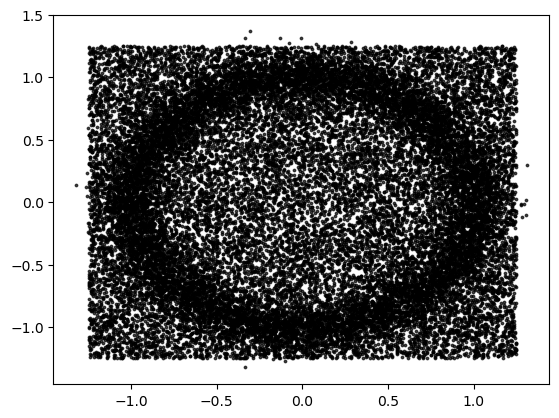

In [4]:
N = 10000  #Noisy signal
M = 20000 #Background noise
t = np.linspace(0, 2*np.pi, N, endpoint=False)
Z = np.empty((t.size, 2))
Z[:, 0] = np.cos(t)
Z[:, 1] = np.sin(t)
Z = Z + 0.1 * rng.standard_normal(Z.shape)
Y = 2.5 * rng.random((M, 2)) - np.array([1.25, 1.25])
Z = np.vstack((Z, Y))
plt.scatter(*Z.T, s=3, alpha=0.7, color="black")

In [5]:
def delaunaycore(points,k=1): 
    kd_tree = KDTree(points)
    k_core_distances, _ = kd_tree.query(points, k=k)
    if k > 1:
        k_core_distances = k_core_distances[:, -1]
    st_alpha = gudhi.AlphaComplex(points=points).create_simplex_tree()
    for face, val in st_alpha.get_filtration():
        max_core = max(k_core_distances[list(face)]) 
        st_alpha.assign_filtration(face, max(val ** 0.5, max_core))
    return st_alpha

/home/odinhg/.local/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

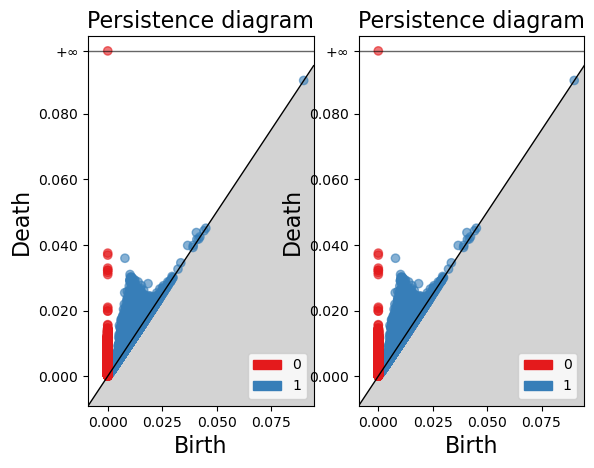

In [6]:
from core import alpha_core
st_del = delaunaycore(points=Z,k=1)
st_al = alpha_core(Z,k=1)
fig, ax = plt.subplots(ncols=2)
gudhi.plot_persistence_diagram(st_del.persistence(), axes=ax[0])
gudhi.plot_persistence_diagram(st_al.persistence(), axes=ax[1])

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

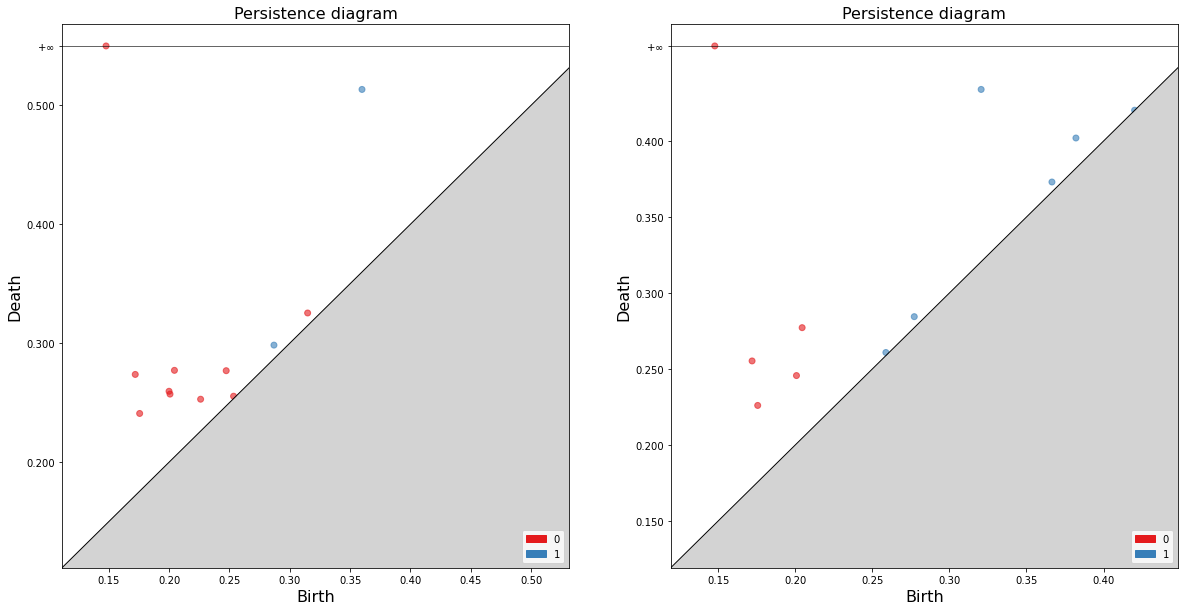

In [10]:
#Compare Alpha-Core with Core
k = 5
st_delcor = delaunaycore(points=X,k=k)
fig, axs = plt.subplots(ncols=2, figsize=(20,10))
st_core = core(X=X,max_dim=2,k=k,return_squared=False)

gudhi.plot_persistence_diagram(st_delcor.persistence(), axes=axs[0])
gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[1])

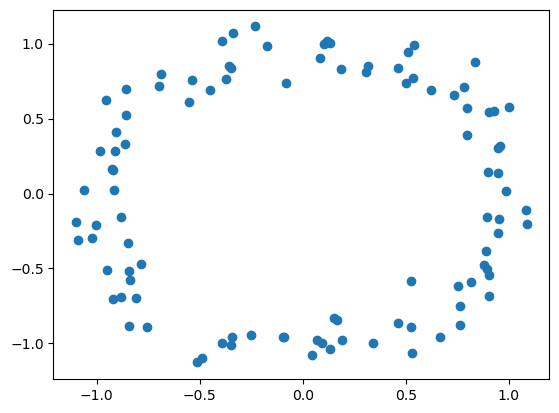

In [87]:
N = 100
M = 0
t = np.linspace(0, 2*np.pi, N, endpoint=False)
X = np.empty((t.size, 2))
X[:, 0] = np.cos(t)
X[:, 1] = np.sin(t)
X = X + 0.1 * rng.standard_normal(X.shape)
Y = 2 * rng.random((M, 2)) - np.array([1, 1])
X = np.vstack((X, Y))
#A = cdist(X, X)
plt.scatter(*X.T)

In [115]:
#Oppdatert gammel kode fra Morten
def core_slope(points, max_dim=1, max_k=None, max_r=None):
    if max_k is None:
        max_k = len(points)
    if max_r is None:
        max_r = 2*np.sqrt(Miniball(points).squared_radius())
    kd_tree = KDTree(points)
    k_core_distances, _ = kd_tree.query(points, k=max_k) 
    line = np.linspace(max_r, 0, num=max_k)
    if max_k>1:
        vertex_indices = np.argmax(line <= k_core_distances, axis=1)
        vertex_values = k_core_distances[np.arange(len(k_core_distances)), vertex_indices]
    else:
        vertex_values = np.array(k_core_distances)
        
    st = gudhi.SimplexTree()
    for dim in range(max_dim + 1):
        for face in combinations(range(len(points)), dim+1):
            face_list = list(face)
            max_core = max(vertex_values[face_list])
            radius = Miniball(X[face_list]).squared_radius() ** 0.5
            st.insert(face, min(max(radius, max_core),max_r))
    return st

In [27]:
t0 = time()
#st_slope = core_slope(points=X, max_dim=2, max_k=6, max_r=100000)
st_slope = core_cech(points=X, max_dim=2, max_k=500, max_r=0.1)

t1 = time()
print(f"Used {t1-t0:.3f} seconds, on {N+M} points.")

Used 2.027 seconds, on 30000 points.


In [25]:
t0 = time()
#st_core = core(X=X,k=5,max_dim=2,return_squared=False)
st_core = core_cech(X,max_k=1,max_dim=2,return_squared=False)
t1 = time()
print(f"Used {t1-t0:.3f} seconds, on {N+M} points.")

Used 2.130 seconds, on 30000 points.


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

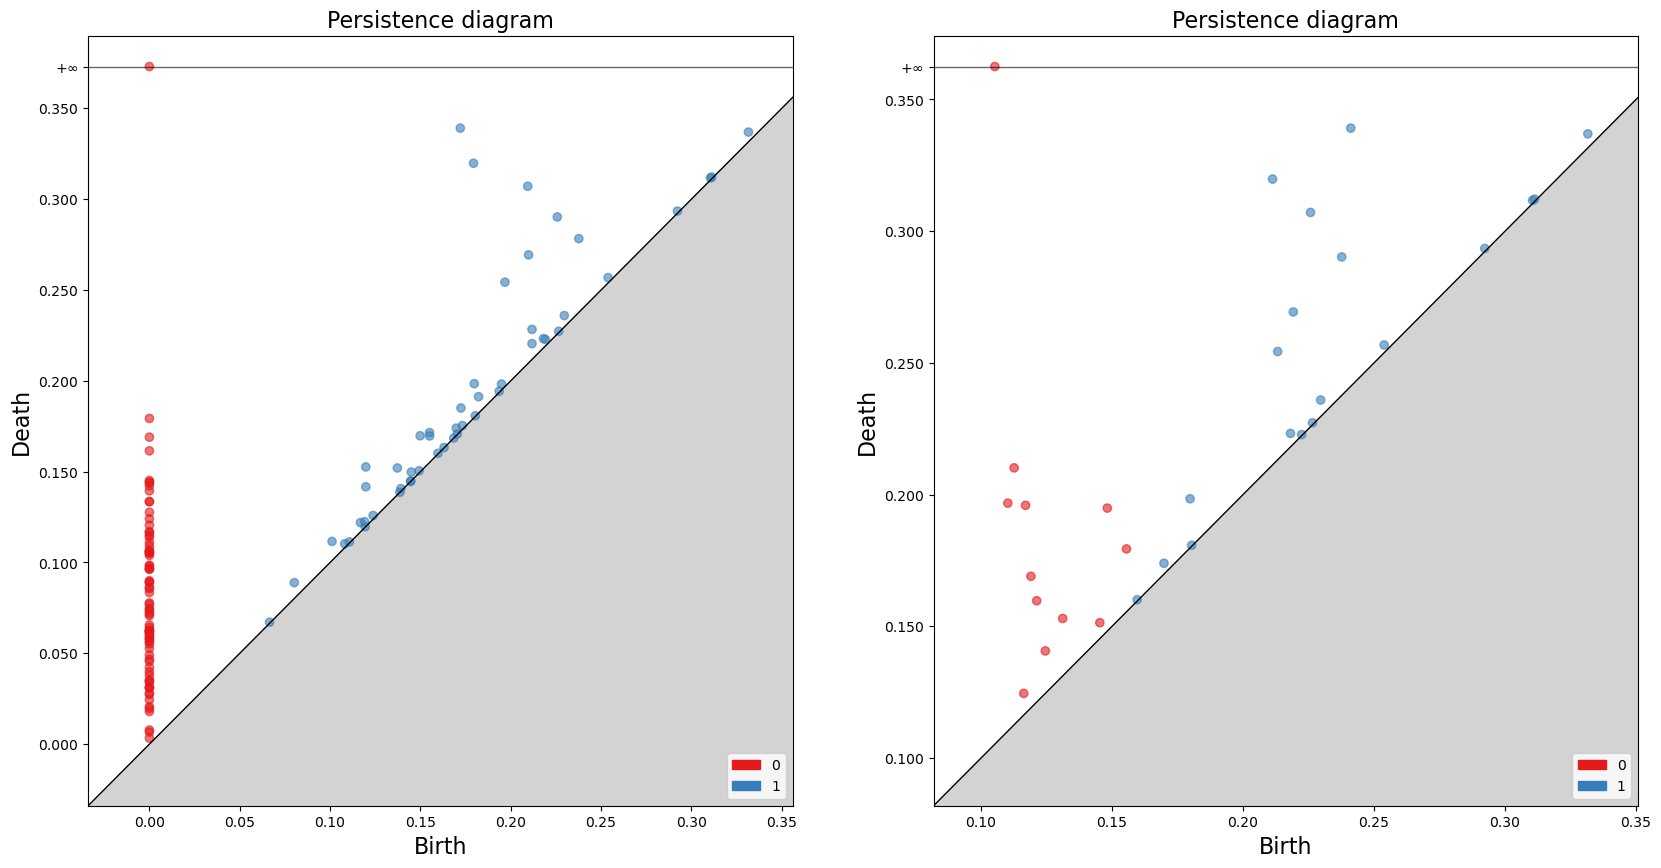

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(20,10))

gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[0])
gudhi.plot_persistence_diagram(st_slope.persistence(), axes=axs[1])

In [7]:
def delaunay_slope(points, max_k=None, max_r=None):
    if max_k is None:
        max_k = len(points)
    if max_r is None:
        max_r = 2*np.sqrt(Miniball(points).squared_radius())
    kd_tree = KDTree(points)
    k_core_distances, _ = kd_tree.query(points, k=max_k)

    line = np.linspace(max_r, 0, num=max_k)
    if max_k>1:
        vertex_indices = np.argmax(line <= k_core_distances, axis=1)
        vertex_values = np.array([k_core_distances[i][j] for i,j in enumerate(vertex_indices)])
    else:
        vertex_values = np.array(k_core_distances)
    st_alpha = gudhi.AlphaComplex(points=points).create_simplex_tree()
    for face, val in st_alpha.get_filtration():
        face_list = list(face)
        max_core = max(vertex_values[face_list])
        new_val = min(max(val ** 0.5, max_core), max_r)
        st_alpha.assign_filtration(face, new_val)
    return st_alpha

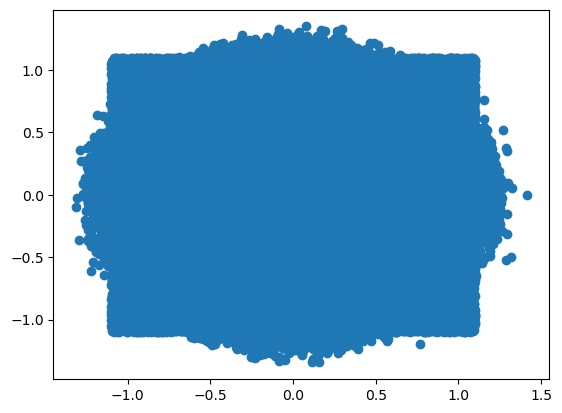

In [8]:
N = 50000  #Noisy signal
M = 50000 #Background noise
t = np.linspace(0, 2*np.pi, N, endpoint=False)
Z = np.empty((t.size, 2))
Z[:, 0] = np.cos(t)
Z[:, 1] = np.sin(t)
Z = Z + 0.1 * rng.standard_normal(Z.shape)
Y = 2.2 * rng.random((M, 2)) - np.array([1.1, 1.1])
Z = np.vstack((Z, Y))
plt.scatter(*Z.T)

st_slope = delaunay_slope(points=Z, max_k=200, max_r=3)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

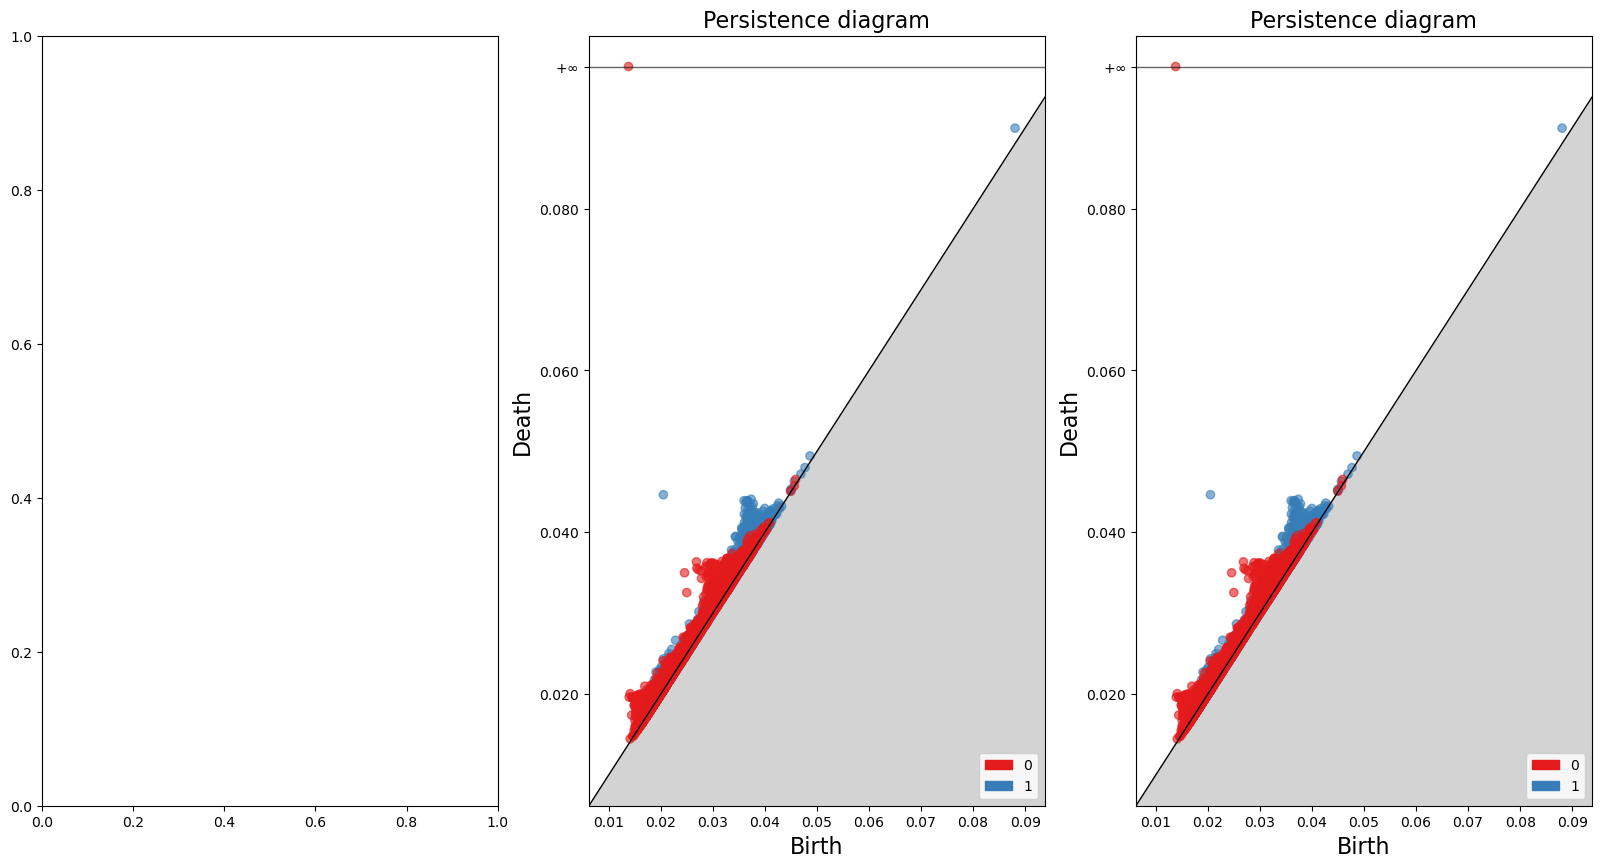

In [12]:
#st_core = delaunaycore(points=Z,k=1)
st_slope = delaunay_slope(points=Z, max_k=50, max_r=0.2)
st_al = alpha_core(points=Z, k=50, max_r=0.2)
fig, axs = plt.subplots(ncols=3, figsize=(20,10))

#gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[0])
gudhi.plot_persistence_diagram(st_slope.persistence(), axes=axs[1])
gudhi.plot_persistence_diagram(st_al.persistence(), axes=axs[2])

In [33]:
points = np.array([[0,0], [1,1], [2,1]])
max_k = 3
max_r = 2
max_dim = 1

#plt.scatter(*points.T)
#plt.show()

kd_tree = KDTree(points)
k_core_distances, _ = kd_tree.query(points, k=max_k-1) 

print(k_core_distances)

line = np.linspace(max_r, 0, num=max_k)
print(line)
line = np.delete(line,-1)
print(line)
vertex_values = np.array(k_core_distances)
print(vertex_values)
if max_k>2:
    vertex_indices = np.argmax(line < k_core_distances, axis=1)
    print(vertex_indices)
    
    for i,j in enumerate(vertex_indices):
        print(i, j - 1)
    
    vertex_values = np.array([k_core_distances[i][j-1] for i,j in enumerate(vertex_indices)])
    print(vertex_values)

#st = gudhi.SimplexTree()
#for dim in range(max_dim + 1):
#    for face in combinations(range(len(points)), dim+1):
#        face_list = list(face)
#        max_core = max(vertex_values[face_list])
#        radius = np.sqrt(Miniball(X[face_list]).squared_radius())
#        st.insert(face, min(max(radius, max_core),max_r))


[[0.         1.41421356]
 [0.         1.        ]
 [0.         1.        ]]
[2. 1. 0.]
[2. 1.]
[[0.         1.41421356]
 [0.         1.        ]
 [0.         1.        ]]
[1 0 0]
0 0
1 -1
2 -1
[0. 1. 1.]
